# Classification problem

The task is to predict if a sales opportunity will result in a won or a lost contract.

In [1]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# Load the data

In [2]:
url = "https://raw.githubusercontent.com/vkrit/data-science-class/master/WA_Fn-UseC_-Sales-Win-Loss.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78025 entries, 0 to 78024
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Opportunity Number                       78025 non-null  int64  
 1   Supplies Subgroup                        78025 non-null  object 
 2   Supplies Group                           78025 non-null  object 
 3   Region                                   78025 non-null  object 
 4   Route To Market                          78025 non-null  object 
 5   Elapsed Days In Sales Stage              78025 non-null  int64  
 6   Opportunity Result                       78025 non-null  object 
 7   Sales Stage Change Count                 78025 non-null  int64  
 8   Total Days Identified Through Closing    78025 non-null  int64  
 9   Total Days Identified Through Qualified  78025 non-null  int64  
 10  Opportunity Amount USD                   78025

# Train-test split

In [5]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.2,
                                     stratify=df["Opportunity Result"], random_state=7)

In [6]:
trainset["Opportunity Result"].value_counts(normalize=True)

Opportunity Result
Loss    0.774079
Won     0.225921
Name: proportion, dtype: float64

In [7]:
testset["Opportunity Result"].value_counts(normalize=True)

Opportunity Result
Loss    0.774111
Won     0.225889
Name: proportion, dtype: float64

In [8]:
print(f"There are {trainset.shape[0]} training and {testset.shape[0]} test instances")

There are 62420 training and 15605 test instances


# Step 3. Exploratory Data Analysis

## Distribution of numerical variables

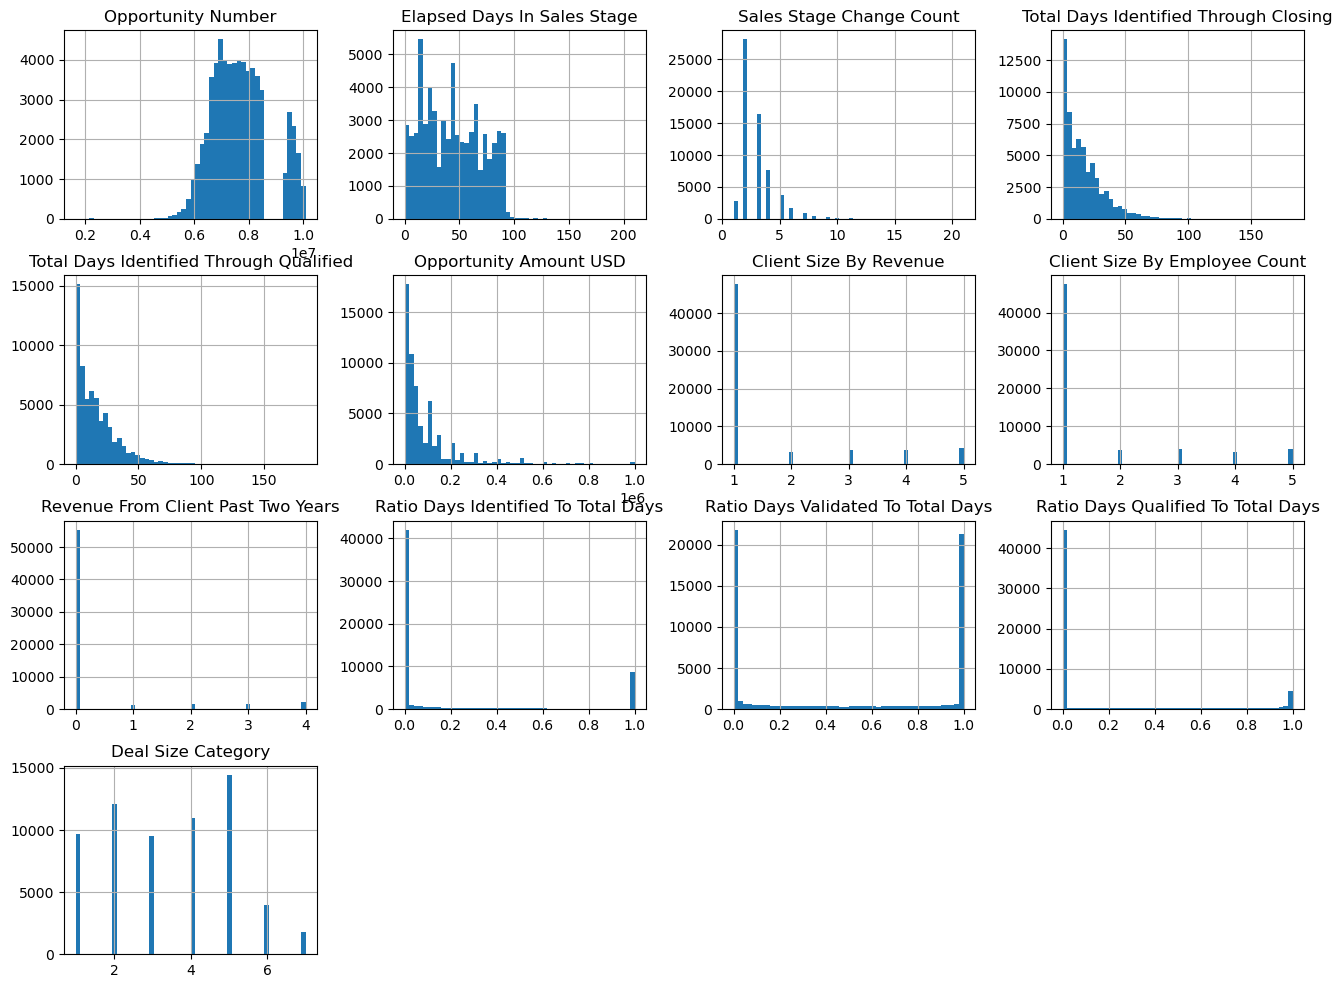

In [9]:
dummy = trainset.hist(bins=50, figsize=(16,12))

In [10]:
trainset[trainset["Opportunity Amount USD"] == 0].shape[0]

1641

In [11]:
trainset[(trainset["Opportunity Amount USD"] == 0) & (trainset["Deal Size Category"] == 1)].shape[0]

1641

## Distribution of categorical variables

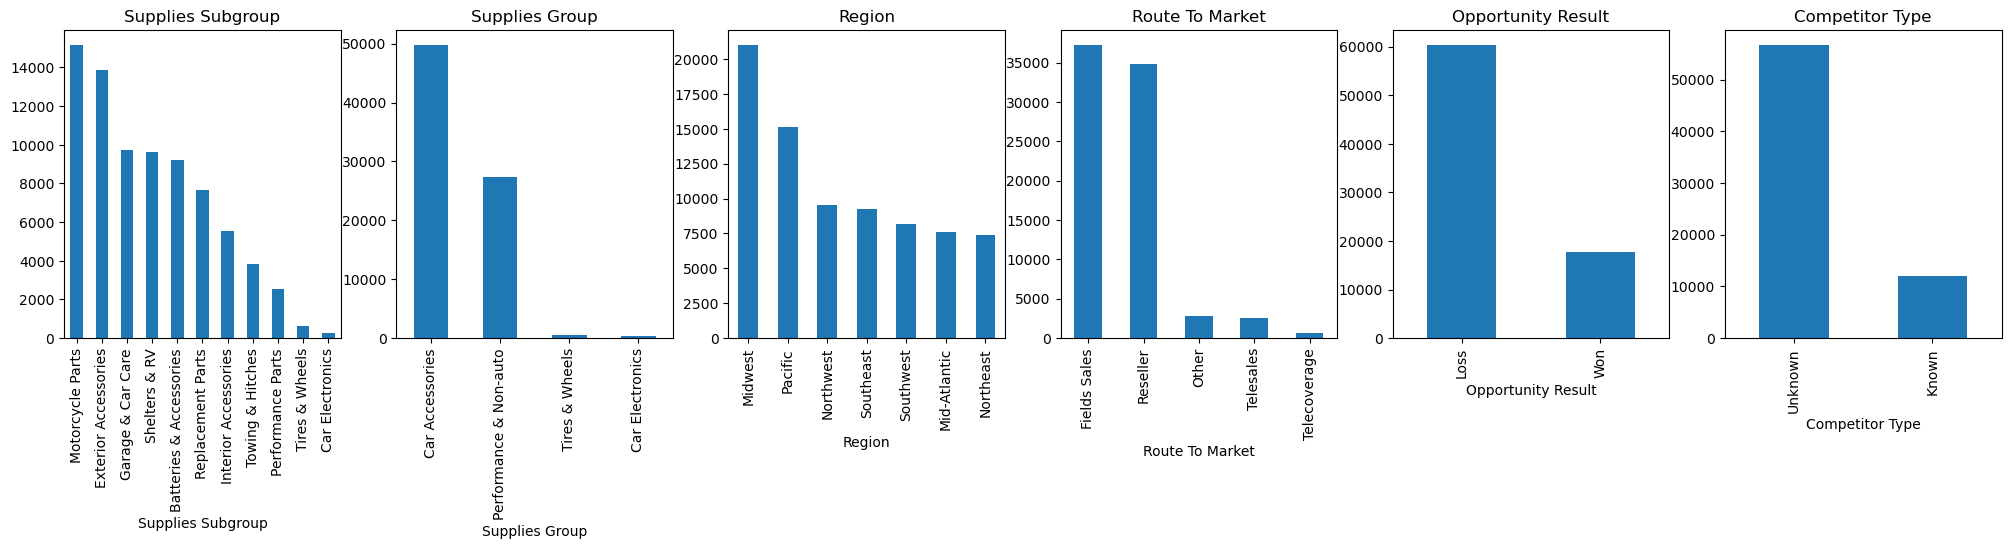

In [12]:
categorical_features = df.select_dtypes(include=['object']).columns

fig, ax = plt.subplots(1, len(categorical_features), figsize=(25, 4))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

# Data cleaning and transformation

## Delete variables

In [13]:
trainset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)
testset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)

## Log-transform right tail-heavy variables

In [14]:
for x in ["Opportunity Amount USD", "Elapsed Days In Sales Stage", "Sales Stage Change Count",
          "Total Days Identified Through Closing", "Total Days Identified Through Qualified"]:
    # add 1 so that 0s remain 0s
    trainset[x] = np.log(trainset[x] + 1)
    testset[x] = np.log(testset[x] + 1)

## Create dummies

In [15]:
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(drop="first", sparse=False)

# categorical columns to transform
cat_cols = ["Supplies Subgroup", "Region", "Route To Market", "Competitor Type"]

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols].to_numpy()
transformed = one_hot_encoder.fit_transform(cat_vals)

# the names of the new columns are the unique values of the categorical variables
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)

# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
trainset.head()

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Region_Northwest,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_Unknown,Competitor Type_nan
8279,Shelters & RV,Pacific,Fields Sales,4.262680,Loss,1.609438,3.258097,3.258097,11.542494,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16176,Shelters & RV,Northwest,Fields Sales,2.833213,Loss,1.791759,4.143135,4.143135,11.918397,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63195,Garage & Car Care,Northeast,Reseller,3.912023,Won,1.386294,2.197225,2.197225,9.014447,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12810,Motorcycle Parts,Pacific,Fields Sales,4.343805,Loss,1.098612,2.302585,2.302585,11.561725,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
54035,Shelters & RV,Mid-Atlantic,Fields Sales,4.454347,Loss,1.098612,1.098612,1.098612,11.695255,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols].to_numpy()
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]
    
# check if the dummies are produced correctly in the testset
testset.head()

,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Region_Northwest,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_Unknown,Competitor Type_nan
60315,Batteries & Accessories,Southeast,Fields Sales,3.828641,Loss,1.609438,3.091042,3.091042,11.824014,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10342,Shelters & RV,Midwest,Fields Sales,4.356709,Loss,1.098612,2.639057,2.639057,11.695255,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37888,Batteries & Accessories,Midwest,Other,3.401197,Loss,1.098612,0.693147,0.693147,11.918397,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2755,Performance Parts,Pacific,Reseller,4.510860,Loss,1.098612,3.295837,3.295837,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
53636,Exterior Accessories,Southeast,Fields Sales,4.343805,Loss,1.386294,2.564949,2.564949,12.456835,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
trainset.drop(columns=cat_cols, inplace=True)
testset.drop(columns=cat_cols, inplace=True)

## Scale features

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# take the target variable out before scaling
trainset_target = trainset["Opportunity Result"].values
trainset_predictors = trainset.drop("Opportunity Result", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(trainset_predictors)
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
trainset['Opportunity Result'] = trainset_target

# inspect the data
trainset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_Unknown,Competitor Type_nan,Opportunity Result
0,0.834715,0.909889,0.778476,0.799311,0.535819,1.112712,-0.499072,-0.325506,0.335908,-0.830850,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-1.630533,-0.366934,Loss
1,-0.767406,1.482327,1.532528,1.534874,0.699966,2.727300,1.983626,-0.325506,-0.418460,1.029264,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-1.630533,-0.366934,Loss
2,0.441705,0.209282,-0.125386,-0.082389,-0.568110,-0.501875,-0.499072,0.750549,-0.555992,-1.061819,...,-0.490519,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,0.613297,-0.366934,Won
3,0.925639,-0.693958,-0.035619,0.005177,0.544217,1.112712,-0.499072,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,0.613297,-0.366934,Loss
4,1.049532,-0.693958,-1.061403,-0.995456,0.602526,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,0.613297,-0.366934,Loss


In [19]:
testset_target = testset["Opportunity Result"].values
testset_predictors = testset.drop("Opportunity Result", axis=1)

scaled_vals = scaler.transform(testset_predictors)
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled target back in
testset['Opportunity Result'] = testset_target

testset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_Unknown,Competitor Type_nan,Opportunity Result
0,0.348252,0.909889,0.636146,0.660471,0.658752,1.112712,1.983626,-0.325506,-0.305543,-0.865456,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-1.630533,-0.366934,Loss
1,0.940101,-0.693958,0.251055,0.284822,0.602526,1.920006,-0.499072,-0.325506,-0.555992,1.141228,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-1.630533,2.725282,Loss
2,-0.130819,-0.693958,-1.406859,-1.332442,0.699966,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,5.151134,-0.897850,-0.089679,-0.180949,0.613297,-0.366934,Loss
3,1.112870,-0.693958,0.810631,0.830677,-4.504476,-0.501875,1.983626,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,0.613297,-0.366934,Loss
4,0.925639,0.209282,0.187915,0.223230,0.935087,-0.501875,-0.499072,-0.325506,-0.293737,-1.090806,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-1.630533,-0.366934,Loss


# Model development

In [20]:
from sklearn.model_selection import GridSearchCV

Xtrain = trainset.drop("Opportunity Result", axis=1)
ytrain = trainset["Opportunity Result"].copy()

## Baseline

In [21]:
# the number of instances belonging to each class
trainset["Opportunity Result"].value_counts()

Opportunity Result
Loss    48318
Won     14102
Name: count, dtype: int64

In [22]:
# total size of the training set
trainset.shape[0]

62420

The baseline classifier will output "Loss" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Loss" label, the accuracy measures will be:

* Precision: 48318/62420 = 0.774

* Recall: 48318/48318 = 1.0

* F-score: 2/(1/precision + 1/recall) = 0.872

For the "Win" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/14102 = 0.0

* F-score: 0.0

The averages of the two classes, i.e. the eventual baseline scores:

* **Precision: 0.387**

* **Recall: 0.5**

* **F-score: 0.436**

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.38703941044537005
Recall: 0.5
F score: 0.4363271866929148


## Random Forest

In [25]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 2 x 2 = 16 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:13:00.348598


In [26]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=500,
                       random_state=7)

In [27]:
grid_search.best_score_

0.8102906903852197

In [28]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

11

In [29]:
rf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    rf_split_test_scores.append(val)

In [30]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
11,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500}",0.891833,0.810291,9.143260
15,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}",0.876036,0.810288,7.505151
10,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.891331,0.810096,9.113922
14,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.875817,0.809274,7.597844
13,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}",0.875299,0.809209,7.550576
9,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}",0.891132,0.809088,9.206745
12,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 10}",0.866884,0.801491,7.543466
8,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.881150,0.800512,9.151449
7,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500}",0.682326,0.679645,0.392936
3,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 500}",0.682378,0.679633,0.402230


In [32]:
feature_importances = grid_search.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

Revenue From Client Past Two Years: 0.143
Total Days Identified Through Qualified: 0.130
Total Days Identified Through Closing: 0.101
Sales Stage Change Count: 0.090
Opportunity Amount USD: 0.086
Elapsed Days In Sales Stage: 0.080
Ratio Days Qualified To Total Days: 0.080
Ratio Days Validated To Total Days: 0.052
Ratio Days Identified To Total Days: 0.049
Deal Size Category: 0.041
Route To Market_Reseller: 0.033
Client Size By Revenue: 0.012
Client Size By Employee Count: 0.012
Competitor Type_Unknown: 0.008
Competitor Type_nan: 0.008
Region_Pacific: 0.007
Region_Midwest: 0.006
Region_Southwest: 0.006
Supplies Subgroup_Motorcycle Parts: 0.006
Supplies Subgroup_Exterior Accessories: 0.005
Supplies Subgroup_Garage & Car Care: 0.005
Supplies Subgroup_Replacement Parts: 0.005
Region_Southeast: 0.005
Region_Northwest: 0.005
Region_Northeast: 0.005
Supplies Subgroup_Shelters & RV: 0.004
Supplies Subgroup_Interior Accessories: 0.004
Route To Market_Telesales: 0.003
Supplies Subgroup_Towing & 

In [33]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/rf-clf.joblib')

['models/rf-clf.joblib']

## Support Vector Machines

### Linear SVMs

In [34]:
start = timer()

from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=5000)

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5, scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: Conv

Execution time HH:MM:SS: 0:09:41.766074


In [35]:
grid_search.best_estimator_

LinearSVC(C=0.1, max_iter=5000, random_state=7)

In [36]:
grid_search.best_score_

0.7077948552002802

In [37]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 0.1},0.709174,0.707795,0.194531
3,{'C': 1},0.709209,0.707706,0.212024
1,{'C': 0.01},0.709007,0.707585,0.200503
4,{'C': 10},0.708831,0.707470,0.191934
0,{'C': 0.001},0.708879,0.707341,0.216977


### Radial Basis Function

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [35]:
start = timer()

from sklearn.svm import SVC

svm = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 2 = 10 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["auto", 0.1],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Took 31370.438645362854 seconds


In [36]:
grid_search.best_estimator_

SVC(C=10, gamma='auto', random_state=7)

In [37]:
grid_search.best_score_

0.7924959305858236

In [38]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

6

In [39]:
# obtain the f-scores of the best models in each split

svmrbf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (at index=best_model_index) from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    svmrbf_split_test_scores.append(val)

In [40]:
print(f"Mean F-score of RF across the folds: {np.array(rf_split_test_scores).mean()}")
print(f"Mean F-score of RBF SVM across the folds: {np.array(svmrbf_split_test_scores).mean()}")

Mean F-score of RF across the folds: 0.8105791924822009
Mean F-score of RBF SVM across the folds: 0.7924959305858236


In [41]:
# return the t-score and a two-tailed p-value
from scipy.stats import ttest_ind

ttest_ind(rf_split_test_scores, svmrbf_split_test_scores)

Ttest_indResult(statistic=7.236699504681401, pvalue=8.920033805623607e-05)

In [42]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
6,"{'C': 10, 'gamma': 'auto'}",0.857211,0.792496,7.549543
8,"{'C': 100, 'gamma': 'auto'}",0.913892,0.781949,14.437389
4,"{'C': 1, 'gamma': 'auto'}",0.804071,0.780950,2.875487
5,"{'C': 1, 'gamma': 0.1}",0.857588,0.773864,9.762799
7,"{'C': 10, 'gamma': 0.1}",0.940061,0.771810,17.897903
9,"{'C': 100, 'gamma': 0.1}",0.973225,0.757243,22.192409
2,"{'C': 0.1, 'gamma': 'auto'}",0.742548,0.735771,0.912674
3,"{'C': 0.1, 'gamma': 0.1}",0.693403,0.676159,2.486972
0,"{'C': 0.01, 'gamma': 'auto'}",0.576839,0.574238,0.450843
1,"{'C': 0.01, 'gamma': 0.1}",0.437147,0.437075,0.016433


In [43]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/svm-rbf-clf.joblib')

['models/svm-rbf-clf.joblib']

### Polynomial SVM

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [45]:
%%script echo skipping # remove this line to run the cell

start = timer()

from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", gamma="scale", random_state=7, degree=2)

# specify the hyperparameters and their values
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm_poly, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Couldn't find program: 'echo'


In [46]:
%%script echo skipping # remove this line to run the cell

print(grid_search.best_estimator_)
print(grid_search.best_score_)

Couldn't find program: 'echo'


In [47]:
%%script echo skipping # remove this line to run the cell

cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

Couldn't find program: 'echo'


# Evaluate the best models

In [15]:
from joblib import load

best_rf = load("models/rf-clf.joblib")
best_svm = load("models/svm-rbf-clf.joblib")

In [16]:
# drop labels for training set, but keep all others
Xtest = testset.drop("Opportunity Result", axis=1)
ytest = testset["Opportunity Result"].copy()

## Random Forest

In [17]:
# rf
yhat = best_rf.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.8479860701161428
Recall: 0.7903791508148983
F score: 0.8135990736025744


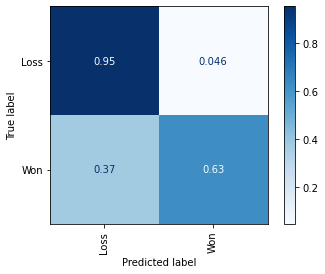

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_rf.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

## SVM

In [21]:
# svm
yhat = best_svm.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.8314108113378981
Recall: 0.7822270560330655
F score: 0.8024669855702284


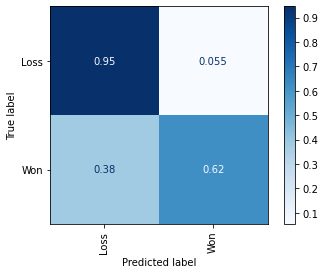

In [22]:
ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
